In [1]:
%%capture
!pip install torcheval

In [2]:
import os
from glob import glob
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import gc
import time
from collections import defaultdict
import random

# visualise data
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch installers
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large
import torch.optim as optim
from torch.optim import lr_scheduler
from torcheval.metrics.functional import multiclass_auprc, multiclass_auroc, multiclass_accuracy, multiclass_f1_score, multilabel_auprc, multilabel_accuracy

# image dataset
import albumentations
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset

# sklearn import
import sklearn
from sklearn.model_selection import StratifiedKFold

In [3]:
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

## Configurations

In [4]:
class cng:
    image_dim = 224
    kfold = 5
    train_batch_size = 32
    valid_batch_size = 64
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = 7
    pretrained_model_path = "/kaggle/input/mobilenet-v3-large-weights/mobilenet_v3_large-weights.pth"
    epochs = 20
#     epochs = 2
    scheduler = "CosineAnnealingLR"
    T_max = 20
    min_lr = 1e-4

## Functions

In [5]:
def prepare_loader(df, fold):
    df_train = df.loc[df["kfold"] != fold, :]
    df_valid = df.loc[df["kfold"] == fold, :]
    
     # train dataset
    train_dataset = meDataset(df_train.reset_index(drop=True), transform=train_transform)
    valid_dataset = meDataset(df_valid.reset_index(drop=True), transform=test_transform)

    train_loader = DataLoader(train_dataset, 
                              batch_size=cng.train_batch_size, 
                              num_workers=2, 
                              shuffle=True, 
                              pin_memory=True, 
                              drop_last=True)
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=cng.valid_batch_size, 
                              num_workers=2, 
                              shuffle=True, 
                              pin_memory=True, 
                              drop_last=True)
    
    return train_loader, valid_loader

In [6]:
def fetch_scheduler(optimizer):
    if cng.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=cng.T_max, 
                                                   eta_min=cng.min_lr)
    elif cng.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=cng.T_0, 
                                                             eta_min=cng.min_lr)
    elif cng.scheduler == None:
        return None
        
    return scheduler

## Load Data

In [7]:
data_dir = '../input/skin-cancer-mnist-ham10000'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [8]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


## Study data

In [9]:
df_original["dx"].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [10]:
df_original["dx_type"].value_counts()

dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

In [11]:
# total_h = []
# total_w = []
# for path in tqdm(df_original["path"]):
#     h, w, _ = cv2.imread(path).shape
#     total_h.append(h)
#     total_w.append(w)

# # images statistics
# print("Mean Height, Width: {}, {}".format(np.mean(total_h), np.mean(total_w)))
# print("Std Height, Width: {}, {}".format(np.std(total_h), np.std(total_w)))

In [12]:
final_df = pd.concat([
    df_original,
    df_original.loc[df_original["dx"]=="nv", :].sample(295, replace=False),
    df_original.loc[df_original["dx"]=="mel", :].sample(1887, replace=True),
    df_original.loc[df_original["dx"]=="bkl", :].sample(1901, replace=True),
    df_original.loc[df_original["dx"]=="bcc", :].sample(986, replace=True),
    df_original.loc[df_original["dx"]=="akiec", :].sample(1173, replace=True),
    df_original.loc[df_original["dx"]=="vasc", :].sample(1358, replace=True),
    df_original.loc[df_original["dx"]=="df", :].sample(1385, replace=True)]
)

final_df.reset_index(drop=True, inplace=True)

In [13]:
final_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [14]:
sgkf = StratifiedKFold(n_splits=cng.kfold)

for fold, ( _, val_) in enumerate(sgkf.split(final_df, final_df.cell_type_idx, final_df.image_id)):
      final_df.loc[val_ , "kfold"] = int(fold)

final_df["kfold"] = final_df["kfold"].astype(int)

## Dataset

In [15]:
class CLAHETransform:
    def __init__(self, clip_limit=(1, 4), p=1.0):
        self.transform = albumentations.CLAHE(clip_limit=clip_limit, p=p)

    def __call__(self, img):
        # Convert PIL image to numpy array
        img_np = np.array(img)
        
        # Apply CLAHE
        augmented = self.transform(image=img_np)
        img_np = augmented['image']
        
        # Convert numpy array back to PIL image
        return Image.fromarray(img_np)

# # Define the complete transformation pipeline
# train_transform = transforms.Compose(
#     [
#         transforms.Resize((cng.image_dim, cng.image_dim), interpolation=Image.NEAREST),  
#         transforms.RandomRotation(25, interpolation=Image.NEAREST),  
#         transforms.RandomAffine(
#             degrees=0, 
#             translate=(0.15, 0.15),  
#             shear=15,  # Shear by 15%
#             interpolation=Image.NEAREST
#         ),
#         transforms.RandomHorizontalFlip(p=1.0),  
#         transforms.RandomVerticalFlip(p=1.0),   
#         transforms.ColorJitter(brightness=(0.9, 1.5)),  
#         CLAHETransform(clip_limit=(1, 4), p=1.0),  
#         transforms.ToTensor()
#     ]
# )

# # Define the complete transformation pipeline
# test_transform = transforms.Compose(
#     [
#         transforms.Resize((cng.image_dim, cng.image_dim), interpolation=Image.NEAREST),  
#         CLAHETransform(clip_limit=(1, 4), p=1.0),  
#         transforms.ToTensor()
#     ]
# )

# Define the complete transformation pipeline
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224), interpolation=Image.NEAREST),  
        transforms.RandomRotation(25, interpolation=Image.NEAREST),  
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.15, 0.15),  
            shear=15,  # Shear by 15%
            interpolation=Image.NEAREST
        ),
        transforms.RandomHorizontalFlip(p=1.0),  
        transforms.RandomVerticalFlip(p=1.0),   
        transforms.ColorJitter(brightness=(0.9, 1.5)),  
        CLAHETransform(clip_limit=(1, 4), p=1.0),  
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758]
        ),
    ]
)

# Define the complete transformation pipeline
test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224), interpolation=Image.NEAREST),  
        CLAHETransform(clip_limit=(1, 4), p=1.0),  
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758]
        ),
    ]
)

In [16]:
class meDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, transform=None):
        self.df = df
        
        if not transform:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])
        else:
            self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'cell_type_idx']
#         enc_label = enc.transform([[label]]).toarray()
        name = self.df.loc[idx, 'lesion_id']
        
        pil_image = Image.open(path)
        torch_image = self.transform(pil_image)
        
#         return torch_image, label, name
        return {
            "image": torch_image, 
            "target": label,
            "imageid": name,
            "one_time": np.array(pil_image)
        }

## Print random images

In [17]:
train_loader, valid_loader = prepare_loader(final_df, fold=1)

In [18]:
x = next(iter(train_loader))

In [19]:
img = x["image"]
raw_image = x["one_time"]

In [20]:
raw_image.shape

torch.Size([32, 450, 600, 3])

In [21]:
import cv2

In [22]:
raw_numpy = raw_image[2].numpy()
edit_numpy = img[2].detach().cpu().permute(1,2,0).numpy()

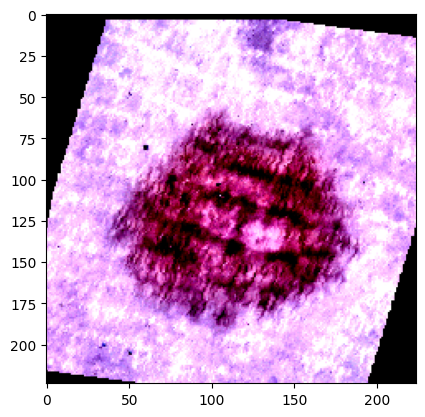

In [23]:
plt.imshow(edit_numpy)

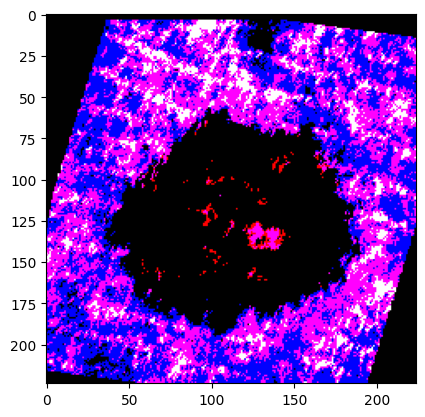

In [24]:
plt.imshow(np.uint8(edit_numpy)*255)

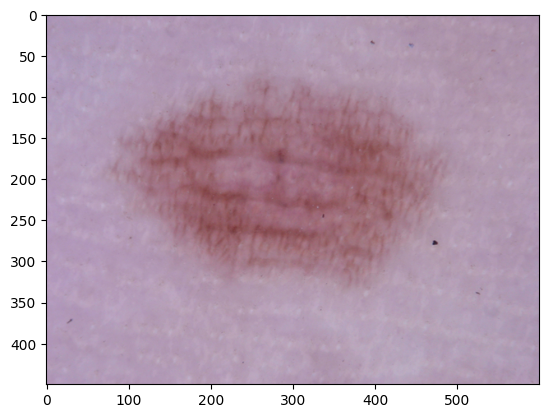

In [25]:
plt.imshow(raw_numpy)

In [26]:
cv2.imwrite("raw1.jpg", cv2.cvtColor(raw_numpy, cv2.COLOR_BGR2RGB))
cv2.imwrite("edit1.jpg", cv2.cvtColor(edit_numpy, cv2.COLOR_BGR2RGB))

True

## Model architecture

In [27]:
class ECANet(nn.Module):
    def __init__(self, k_size=3):
        super(ECANet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

In [28]:
class MobileNetV3WithECA(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3WithECA, self).__init__()
        self.mobilenet_v3 = mobilenet_v3_large(pretrained=False)
        self.mobilenet_v3.load_state_dict(torch.load(cng.pretrained_model_path))
        se_layers = [4, 5, 6, 11, 12, 13, 14, 15]
        
        # Replace SE blocks with ECA blocks in InvertedResidual blocks
        for i in se_layers:
            setattr(self.mobilenet_v3.features[i].block, "2", ECANet())
        
        # Transfer Learning
        in_features = self.mobilenet_v3.classifier[3].in_features
        self.mobilenet_v3.classifier[3] = nn.Linear(in_features, num_classes, bias=True)

    def forward(self, x):
        return self.mobilenet_v3(x)

In [29]:
model = MobileNetV3WithECA(num_classes=cng.num_classes)
model.to(cng.device)
print("Model loaded!")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded!


## Train-Validation functions

In [30]:
def train_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_auprc = 0.0
    running_accuracy = 0.0   
    running_f1 = 0.0  
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    
    for step, data in bar:
        images = data["image"].to(device)
        targets = data["target"].to(device, dtype=torch.long)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        batch_size = images.shape[0]
        
        running_loss += (loss.item() * batch_size)
        running_auroc += (multiclass_auroc(outputs, targets, num_classes=cng.num_classes).item() * batch_size)
        running_auprc += (multiclass_auprc(outputs, targets).item() * batch_size)
        running_accuracy += (multiclass_accuracy(outputs, targets).item() * batch_size) 
        running_f1 += (multiclass_f1_score(outputs, targets).item() * batch_size)  
    
    epoch_loss = running_loss / (len(dataloader) * batch_size)
    epoch_auroc = running_auroc / (len(dataloader) * batch_size)
    epoch_auprc = running_auprc / (len(dataloader) * batch_size)
    epoch_accuracy = running_accuracy / (len(dataloader) * batch_size)
    epoch_f1 = running_f1 / (len(dataloader) * batch_size)
    
    bar.set_postfix(Epoch=epoch, Train_Loss=running_loss, Train_Auroc=running_auroc, LR=optimizer.param_groups[0]['lr'])
    return epoch_loss, epoch_auroc, epoch_auprc, epoch_accuracy, epoch_f1

In [31]:
def valid_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_auprc = 0.0
    running_accuracy = 0.0   
    running_f1 = 0.0  
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    
    for step, data in bar:
        images = data["image"].to(device)
        targets = data["target"].to(device, dtype=torch.long)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        batch_size = images.shape[0]
        
        running_loss += (loss.item() * batch_size)
        running_auroc += (multiclass_auroc(outputs, targets, num_classes=cng.num_classes).item() * batch_size)
        running_auprc += (multiclass_auprc(outputs, targets).item() * batch_size)
        running_accuracy += (multiclass_accuracy(outputs, targets).item() * batch_size) 
        running_f1 += (multiclass_f1_score(outputs, targets).item() * batch_size)  
    
    epoch_loss = running_loss / (len(dataloader) * batch_size)
    epoch_auroc = running_auroc / (len(dataloader) * batch_size)
    epoch_auprc = running_auprc / (len(dataloader) * batch_size)
    epoch_accuracy = running_accuracy / (len(dataloader) * batch_size)
    epoch_f1 = running_f1 / (len(dataloader) * batch_size)
    
    bar.set_postfix(Epoch=epoch, Train_Loss=running_loss, Train_Auroc=running_auroc, LR=optimizer.param_groups[0]['lr'])
    return epoch_loss, epoch_auroc, epoch_auprc, epoch_accuracy, epoch_f1

## Running

In [32]:
try:
    os.mkdir("/kaggle/working//weights")
except:
    print("Path already exists")

In [33]:
# torch.save(model.state_dict(), "/kaggle/working//weights/{}.pth".format(1))
# model = torch.load("/kaggle/working//weights/{}.pth".format(1))

In [34]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        print("EPOCH {} ----------------------------------------------".format(epoch))
        gc.collect()
        train_epoch_loss, train_epoch_auroc, train_epoch_auprc, train_epoch_accuracy, train_epoch_f1 = train_epoch(model, 
                                                                                                                   optimizer, 
                                                                                                                   scheduler=None, 
                                                                                                                   dataloader=train_loader, 
                                                                                                                   device=cng.device, 
                                                                                                                   epoch=epoch)
        
        torch.save(model.state_dict(), "/kaggle/working//weights/{}.pth".format(epoch))
        
        val_epoch_loss, val_epoch_auroc, val_epoch_auprc, val_epoch_accuracy, val_epoch_f1 = valid_epoch(model, 
                                                                                                         valid_loader, 
                                                                                                         device=cng.device, 
                                                                                                         epoch=epoch)
        
        print("Learning rate: {}".format(optimizer.param_groups[0]["lr"]))
        if scheduler is not None:
            scheduler.step()
            
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        
        history['Train AUPRC'].append(train_epoch_auprc)
        history['Valid AUPRC'].append(val_epoch_auprc)
        
        history['Train ACCURACY'].append(train_epoch_accuracy)
        history['Valid ACCURACY'].append(val_epoch_accuracy)
        
        history['Train F1'].append(train_epoch_f1)
        history['Valid F1'].append(val_epoch_f1)
        
        print("Scheduler lr: {}".format(scheduler.get_last_lr()))
#         print("New learning rate: {}".format(optimizer.param_groups[0]["lr"]))
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
#             best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
#             torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
#             print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
#     model.load_state_dict(best_model_wts)
    
    return model, history

In [35]:
train_loader, valid_loader = prepare_loader(final_df, fold=1)

In [36]:
optimizer = optim.Adam(model.parameters(), 
                       lr=1e-3, 
                       weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = fetch_scheduler(optimizer)

In [37]:
model, history = run_training(model, optimizer, 
                              scheduler=scheduler,
                              device=cng.device,
                              num_epochs=cng.epochs)

[INFO] Using GPU: Tesla T4

EPOCH 1 ----------------------------------------------


100%|██████████| 59/59 [00:28<00:00,  2.04it/s]


Learning rate: 0.001
Scheduler lr: [0.000994459753267812]
Validation AUROC Improved (-inf ---> 0.9441774699647548)

EPOCH 2 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.68it/s]


Learning rate: 0.000994459753267812
Scheduler lr: [0.000977975432332819]

EPOCH 3 ----------------------------------------------


100%|██████████| 59/59 [00:23<00:00,  2.55it/s]


Learning rate: 0.000977975432332819
Scheduler lr: [0.0009509529358847653]
Validation AUROC Improved (0.9441774699647548 ---> 0.9630925766492294)

EPOCH 4 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.57it/s]


Learning rate: 0.0009509529358847653
Scheduler lr: [0.0009140576474687262]

EPOCH 5 ----------------------------------------------


100%|██████████| 59/59 [00:21<00:00,  2.72it/s]


Learning rate: 0.0009140576474687262
Scheduler lr: [0.0008681980515339462]
Validation AUROC Improved (0.9630925766492294 ---> 0.9677397487527233)

EPOCH 6 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.65it/s]


Learning rate: 0.0008681980515339462
Scheduler lr: [0.0008145033635316127]

EPOCH 7 ----------------------------------------------


100%|██████████| 59/59 [00:21<00:00,  2.69it/s]


Learning rate: 0.0008145033635316127
Scheduler lr: [0.0007542957248827959]

EPOCH 8 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.67it/s]


Learning rate: 0.0007542957248827959
Scheduler lr: [0.0006890576474687263]
Validation AUROC Improved (0.9677397487527233 ---> 0.9719650321087595)

EPOCH 9 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.64it/s]


Learning rate: 0.0006890576474687263
Scheduler lr: [0.0006203955092681039]

EPOCH 10 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.66it/s]


Learning rate: 0.0006203955092681039
Scheduler lr: [0.0005499999999999999]
Validation AUROC Improved (0.9719650321087595 ---> 0.9736418845289845)

EPOCH 11 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.59it/s]


Learning rate: 0.0005499999999999999
Scheduler lr: [0.00047960449073189616]

EPOCH 12 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.65it/s]


Learning rate: 0.00047960449073189616
Scheduler lr: [0.0004109423525312736]
Validation AUROC Improved (0.9736418845289845 ---> 0.9792052224531012)

EPOCH 13 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Learning rate: 0.0004109423525312736
Scheduler lr: [0.0003457042751172039]
Validation AUROC Improved (0.9792052224531012 ---> 0.9800240801552594)

EPOCH 14 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.67it/s]


Learning rate: 0.0003457042751172039
Scheduler lr: [0.0002854966364683871]
Validation AUROC Improved (0.9800240801552594 ---> 0.980113050695193)

EPOCH 15 ----------------------------------------------


100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Learning rate: 0.0002854966364683871
Scheduler lr: [0.00023180194846605365]

EPOCH 16 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Learning rate: 0.00023180194846605365
Scheduler lr: [0.0001859423525312737]
Validation AUROC Improved (0.980113050695193 ---> 0.9824360811104209)

EPOCH 17 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.67it/s]


Learning rate: 0.0001859423525312737
Scheduler lr: [0.0001490470641152345]
Validation AUROC Improved (0.9824360811104209 ---> 0.9826144475047871)

EPOCH 18 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.66it/s]


Learning rate: 0.0001490470641152345
Scheduler lr: [0.00012202456766718092]

EPOCH 19 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.68it/s]


Learning rate: 0.00012202456766718092
Scheduler lr: [0.00010554024673218806]

EPOCH 20 ----------------------------------------------


100%|██████████| 59/59 [00:22<00:00,  2.67it/s]

Learning rate: 0.00010554024673218806
Scheduler lr: [0.0001]
Validation AUROC Improved (0.9826144475047871 ---> 0.9830087908243729)

Training complete in 0h 43m 28s
Best AUROC: 0.9830


Train Loss


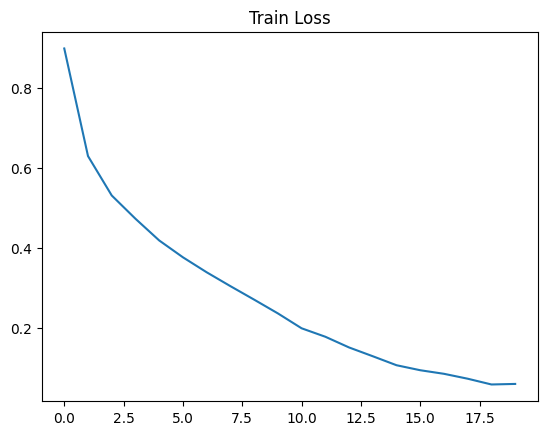

Valid Loss


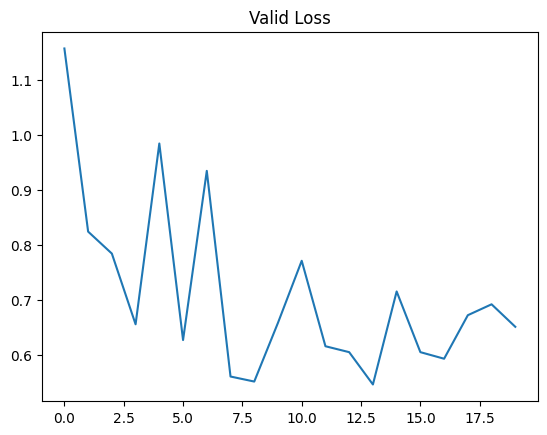

Train AUROC


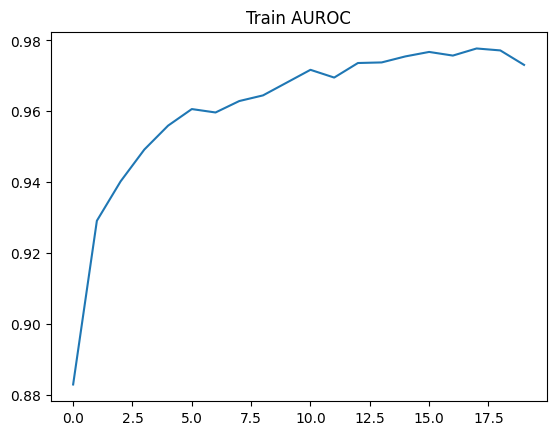

Valid AUROC


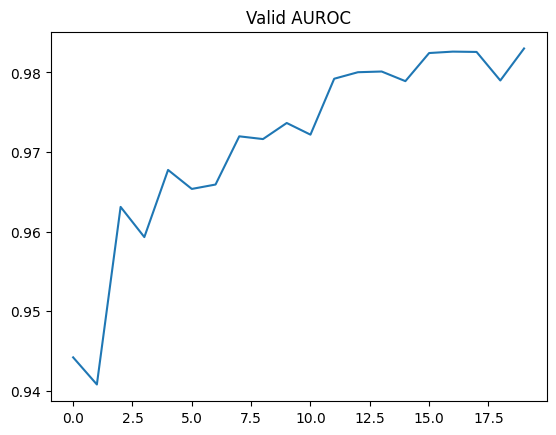

Train AUPRC


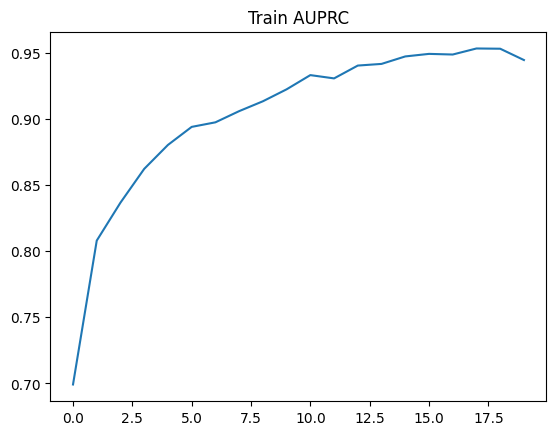

Valid AUPRC


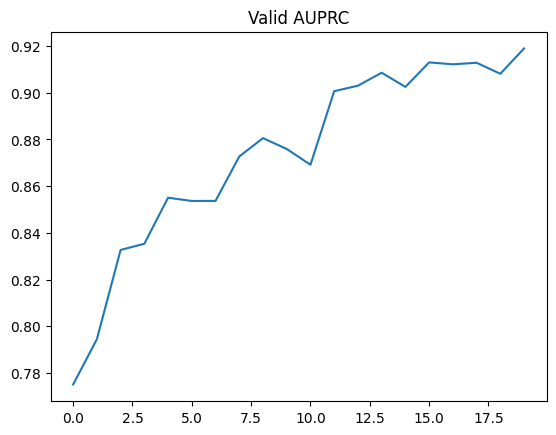

Train ACCURACY


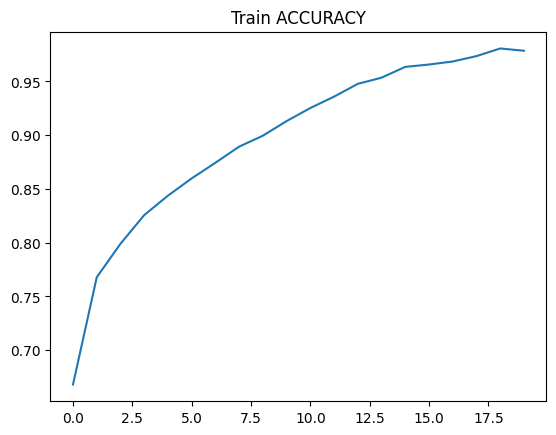

Valid ACCURACY


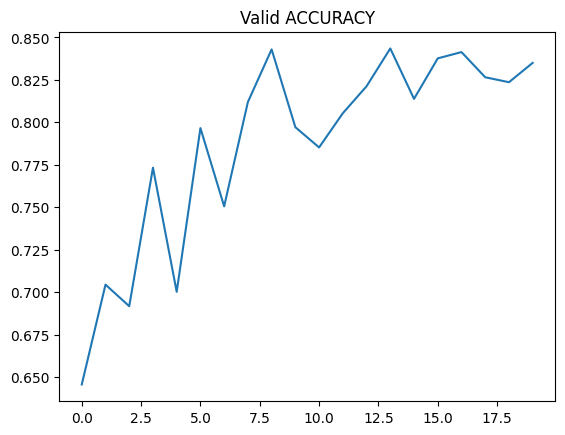

Train F1


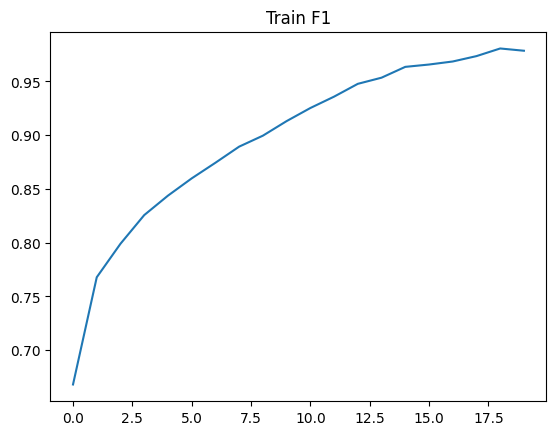

Valid F1


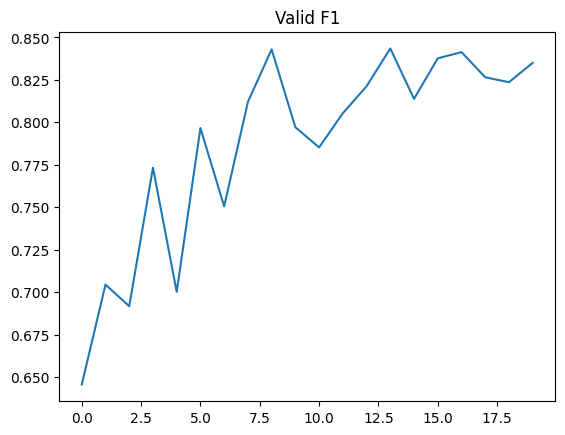

In [38]:
for key in history.keys(): 
    print(key)
    
    my_array = np.array(history[key])
    np.save('{}.npy'.format(key), my_array)
    
    plt.plot(history[key])
    plt.title(key)
    plt.savefig("{}.jpg".format(key))
    plt.show()

In [39]:
np.save('my_array.npy', my_array)

# Load the array from the file
loaded_array = np.load('my_array.npy')

print(loaded_array)

[0.64565678 0.70444915 0.69173729 0.77330508 0.70021186 0.79661017
 0.75052966 0.81197034 0.84295551 0.79713983 0.78522246 0.80534958
 0.82123941 0.84348517 0.81382415 0.8376589  0.84136653 0.82653602
 0.82362288 0.83501059]


In [40]:
for key in history.keys():
          
    my_array = np.array(history[key])
    np.save('{}.npy'.format(key), my_array)


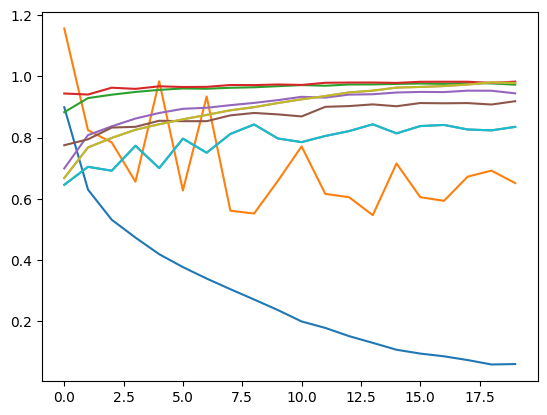

In [41]:
for key in history.keys():
    loaded_array = np.load('{}.npy'.format(key))
    plt.plot(loaded_array)
